In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from itertools import combinations

style.use('ggplot')
last_2_digits_student_id = 50
np.random.seed(last_2_digits_student_id)

In [110]:
#Set up the environment
K = 5 # number of articles
T = 1000 # horizon

article_combinations = list(combinations(range(K), 2))
L = len(article_combinations) #number of arms
N = np.power(T/L,2/3).astype(int) #explore horizon for Explore then Exploit method

article_click_probabilites = np.random.uniform(0.0,0.7,K)

def arm_click_probability(index_i, index_j):
  p_i = article_click_probabilites[index_i]
  p_j = article_click_probabilites[index_j]
  #return p_i + (1 - p_i) * p_j
  return p_i + p_j - p_i * p_j

arm_true = {pair: arm_click_probability(*pair) for pair in article_combinations}
max_arm = max(arm_true, key=arm_true.get)
max_value = arm_true[max_arm]
print("The best arm is", max_arm, "with a reward of", round(max_value,5))

The best arm is (0, 3) with a reward of 0.5276


In [111]:
#Perform learning
r_total_ee = np.zeros(T)
r_total_ucb = np.zeros(T)
theoretical_regret = np.zeros(T)
deltas = {pair: max_value - arm_true[pair] for pair in article_combinations if arm_true[pair] < max_value}
epochs = 50

for e in range(epochs):
  #Explore then exploit
  arm_est_ee = {pair: 0 for pair in article_combinations}
  rewards_explore = {pair: np.zeros(N) for pair in article_combinations}

  for arm in article_combinations:
    rewards_explore[arm] = np.random.binomial(1,p = arm_true[arm], size = N)
    arm_est_ee[arm] = np.mean(rewards_explore[arm])
  chosen_arm_ee = max(arm_est_ee, key=arm_est_ee.get)
  print("(EE) Epoch", e, ": chosen arm is", chosen_arm_ee, "with a reward of", round(arm_est_ee[chosen_arm_ee],5))

  rewards_exploit = np.random.binomial(1,p = arm_true[chosen_arm_ee],size = T-N*L)
  reward_per_slot = np.concatenate(list(rewards_explore.values()) + [rewards_exploit])
  r_total_ee += reward_per_slot.cumsum()

  #UCB
  arm_counts = {pair: 0 for pair in article_combinations}
  arm_est_ucb = {pair: 0 for pair in article_combinations}
  rewards_ucb = np.zeros(T)

  for t in range(1,T+1):

    #calculating theoretical regret
    regret_contribution = np.sum([8 * np.log(t) / delta for delta in deltas.values() if delta > 0])
    theoretical_regret[t - 1] = regret_contribution

    #performing UCB learning
    if 0 in arm_counts.values():
      unused_arms = [key for key, value in arm_counts.items() if value == 0]
      chosen_arm_ucb = unused_arms[0] if unused_arms else None
    else:
      ucb_values = {
          pair: arm_est_ucb[pair] + np.sqrt(2 * np.log(T) / arm_counts[pair]) #parameter = 2 in original
          for pair in article_combinations
      }
      chosen_arm_ucb = max(ucb_values, key=ucb_values.get)
    rewards_ucb[t-1] = np.random.binomial(1, arm_true[chosen_arm_ucb])
    arm_counts[chosen_arm_ucb] += 1
    arm_est_ucb[chosen_arm_ucb] += (rewards_ucb[t-1] - arm_est_ucb[chosen_arm_ucb]) / arm_counts[chosen_arm_ucb]
  r_total_ucb += rewards_ucb.cumsum()
  print("(UCB) Epoch", e, ": chosen arm is", chosen_arm_ucb, "with a reward of:", round(arm_est_ucb[chosen_arm_ucb],5))


(EE) Epoch 0 : chosen arm is (0, 2) with a reward of 0.66667
(UCB) Epoch 0 : chosen arm is (0, 1) with a reward of: 0.4717
(EE) Epoch 1 : chosen arm is (3, 4) with a reward of 0.61905
(UCB) Epoch 1 : chosen arm is (0, 4) with a reward of: 0.4863
(EE) Epoch 2 : chosen arm is (1, 3) with a reward of 0.7619
(UCB) Epoch 2 : chosen arm is (3, 4) with a reward of: 0.47107
(EE) Epoch 3 : chosen arm is (0, 2) with a reward of 0.52381
(UCB) Epoch 3 : chosen arm is (3, 4) with a reward of: 0.53896
(EE) Epoch 4 : chosen arm is (0, 2) with a reward of 0.61905
(UCB) Epoch 4 : chosen arm is (0, 3) with a reward of: 0.52318
(EE) Epoch 5 : chosen arm is (0, 3) with a reward of 0.66667
(UCB) Epoch 5 : chosen arm is (0, 2) with a reward of: 0.38356
(EE) Epoch 6 : chosen arm is (0, 3) with a reward of 0.57143
(UCB) Epoch 6 : chosen arm is (0, 3) with a reward of: 0.54545
(EE) Epoch 7 : chosen arm is (0, 3) with a reward of 0.61905
(UCB) Epoch 7 : chosen arm is (2, 4) with a reward of: 0.44444
(EE) Epoch 

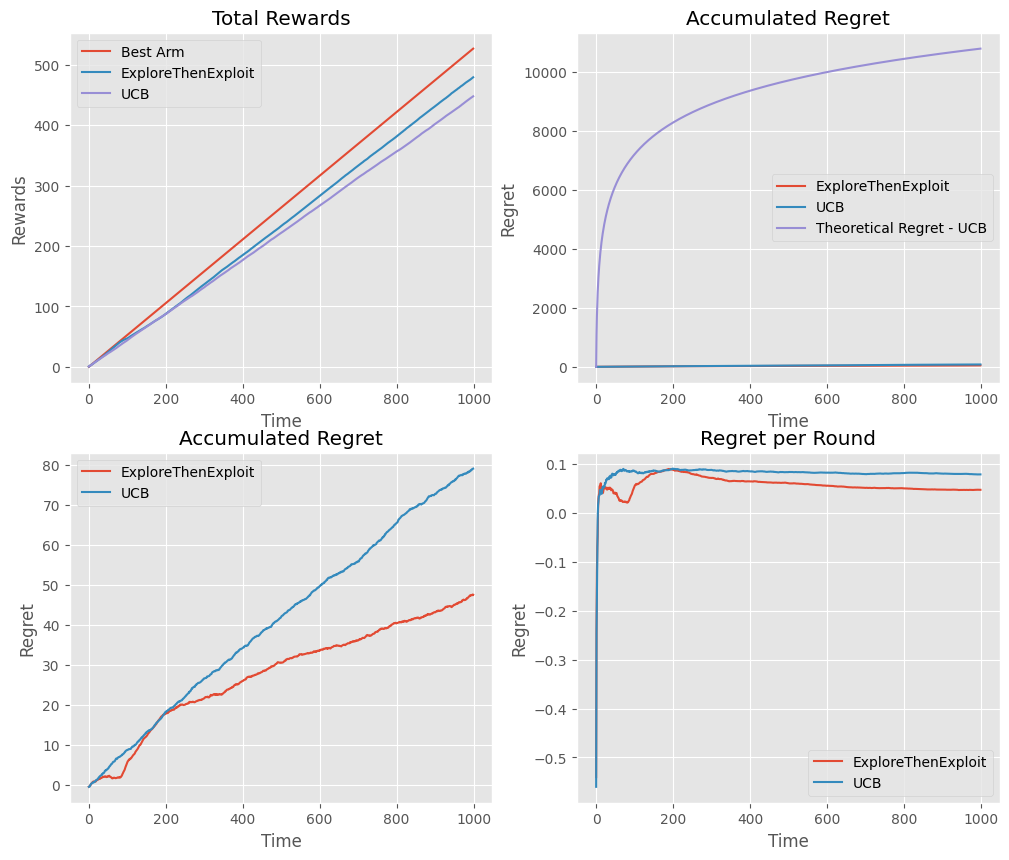

<Figure size 640x480 with 0 Axes>

In [112]:
#Plot results
r_avg_tot_ee = r_total_ee/epochs
r_avg_tot_ucb = r_total_ucb/epochs
fig, ax = plt.subplots(2,2,figsize = (12,10))
plt.figure()

x = np.arange(T)
best = x * max_value
ax[0, 0].plot(x,best,label = 'Best Arm')
ax[0, 0].plot(x,r_avg_tot_ee,label = 'ExploreThenExploit')
ax[0, 0].plot(x,r_avg_tot_ucb,label = 'UCB')
ax[0, 0].set_xlabel('Time')
ax[0, 0].set_ylabel('Rewards')
ax[0, 0].set_title('Total Rewards')
ax[0, 0].legend()

ax[0, 1].plot(x,best-r_avg_tot_ee, label = 'ExploreThenExploit')
ax[0, 1].plot(x,best-r_avg_tot_ucb, label = 'UCB')
ax[0, 1].plot(x, theoretical_regret, label = 'Theoretical Regret - UCB')
ax[0, 1].set_xlabel('Time')
ax[0, 1].set_ylabel('Regret')
ax[0, 1].set_title('Accumulated Regret')
ax[0, 1].legend()

ax[1, 0].plot(x,best-r_avg_tot_ee, label = 'ExploreThenExploit')
ax[1, 0].plot(x,best-r_avg_tot_ucb, label = 'UCB')
ax[1, 0].set_xlabel('Time')
ax[1, 0].set_ylabel('Regret')
ax[1, 0].set_title('Accumulated Regret')
ax[1, 0].legend()

ax[1, 1].plot(x,(best-r_avg_tot_ee)/(x+1),label = 'ExploreThenExploit')
ax[1, 1].plot(x,(best-r_avg_tot_ucb)/(x+1),label = 'UCB')
ax[1, 1].set_xlabel('Time')
ax[1, 1].set_ylabel('Regret')
ax[1, 1].set_title('Regret per Round')
ax[1, 1].legend()

plt.show()